In [42]:
import pandas as pd
import numpy as np
from datetime import datetime
import requests
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML
rc('animation', html='html5')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from tqdm.notebook import trange
from tensorboardX import SummaryWriter


#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
TB_LOG_PATH = '/notebooks/tboardlogs/learn_sir_model/{}'

In [43]:
# Save: Apr01_18-41-54

#  Download Data of Novel Coronavirus (COVID-19) Cases, provided by JHU CSSE 

In [44]:
base_url = ('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/'
            'csse_covid_19_data/csse_covid_19_time_series/{}')
urls = {
    'infected': base_url.format('time_series_covid19_confirmed_global.csv'),
    'dead': base_url.format('time_series_covid19_deaths_global.csv'),
    'recovered': base_url.format('time_series_covid19_recovered_global.csv'),
}

datasets = {k: pd.read_csv(urls[k]) for k in urls}
infected = datasets['infected']
dead = datasets['dead']
recovered = datasets['recovered']

,infected,dead,recovered
2020-01-22,555,17,28
2020-01-23,654,18,30
2020-01-24,941,26,36
2020-01-25,1434,42,39
2020-01-26,2118,56,52


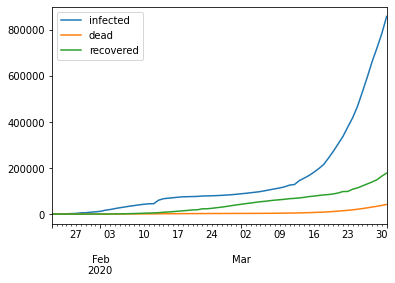

In [45]:
world_data = pd.DataFrame({k: datasets[k].sum(axis=0) for k in datasets})
world_data = world_data[world_data.index.str.endswith('20')]
world_data.index = pd.to_datetime(world_data.index)
world_data.plot()
world_data.head()

# SIR model using Torch


$\dot S(t) = -b S(t)I(t)$

$\dot I(t) = bS(t)I(t) - kI(t)$

$\dot R(t) = kI(t)$

tensor([3.1570])
None


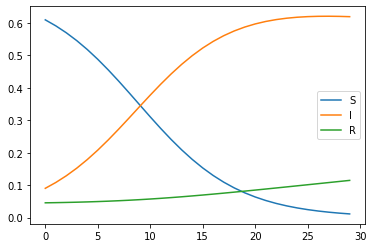

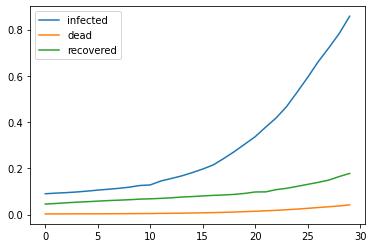

In [84]:
from torchdiffeq import odeint
from torch.autograd import Variable

#device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

first_day = 40
real_data = torch.FloatTensor(world_data.values.astype(float))[first_day:, :] / 1e6
real_data = real_data.to(device)


b = Variable(torch.rand(1).to(device)**2, requires_grad=True)
k = Variable(torch.rand(1).to(device)**2, requires_grad=True)
S0 = Variable(torch.rand(1).to(device)**2, requires_grad=True)
I0 = Variable(torch.tensor([real_data[0,0]]), requires_grad=True)
R0 = Variable(torch.tensor([real_data[0,2]]), requires_grad=True)

def SIRFunc(t, x):
    S, I, R = x[0], x[1], x[2]
    #dot = Variable(torch.zeros(3), requires_grad=True)
    dot = torch.empty(3, requires_grad=False).to(device)
    dot[0] = -b * S*I
    dot[1] = b*S*I - k*I
    dot[2] = k*I
    
    return dot




def loss_fct(xt, all_params):
    alpha = 1e-2
    real_infected = real_data[:,0]
    real_recovered = real_data[:, 2]
    torch_infected = xt[:, 1]
    torch_recovered = xt[:, 2]
    
    return torch.norm(real_infected - torch_infected) +\
           torch.norm(real_recovered- torch_recovered) #-\
                 #alpha * (torch.sum(torch.log(all_params)))


x0 = torch.cat([S0, I0, R0])
t = torch.FloatTensor(np.arange(len(real_data))).to(device)
xt = odeint(SIRFunc, x0, t)


pd.DataFrame(xt.cpu().detach().numpy(), columns=list('SIR')).plot()
pd.DataFrame(real_data.cpu().detach().numpy(), columns=world_data.columns).plot()
loss = loss_fct(xt, torch.cat([S0, I0, R0, k, b]))
loss.backward()
print(S0.grad)
print(x0[0].grad)

# Learn

In [85]:
writer_log_path = TB_LOG_PATH.format(datetime.now().strftime('%b%d_%H-%M-%S'))
writer = SummaryWriter(writer_log_path)
print(writer_log_path)

all_params = [b, k, S0, I0, R0]
optimizer = optim.Adam(all_params, lr=1e-2)
t = torch.FloatTensor(np.arange(len(real_data))).to(device)
loss_history = []

infected_history = []
recovered_history = []


for i in trange(300):
    optimizer.zero_grad()
    x0 = torch.cat([S0, I0, R0])
    xt = odeint(SIRFunc, x0, t)
    #print(xt[0])
    loss = loss_fct(xt, torch.cat([S0, I0, R0, k, b]))
    loss.backward()
    optimizer.step()

    writer.add_scalar('params/k', k.item(), i)
    writer.add_scalar('params/b', b.item(), i)
    writer.add_scalar('init/S0', S0.item(), i)
    writer.add_scalar('init/I0', I0.item(), i)
    writer.add_scalar('init/R0', R0.item(), i)

    writer.add_scalar('loss', loss.item(), i)
    writer.add_scalar(
        'grad/norm',
        np.linalg.norm(
            list(map(lambda u: u.grad.cpu().detach().numpy(), all_params))), i)

    
    infected_history.append(xt[:, 1].cpu().detach().numpy())
    recovered_history.append(xt[:, 2].cpu().detach().numpy())
    
    # infected
    fig = plt.figure()
    plt.plot(infected_history[-1], 'r', label='infected (learned)')
    plt.plot(real_data[:, 0].cpu().detach().numpy(), 'r--', label='infected (real)')
    plt.ylabel('number (in millions)')
    plt.legend()
    plt.ylim(0, 1)
    writer.add_figure('time evolution/infected', fig, i)
    plt.close()

    
    # recovered
    fig = plt.figure()
    plt.plot(recovered_history[-1], 'b', label='recovered (learned)')
    plt.plot(real_data[:, 2].cpu().detach().numpy(), 'b--', label='recovered (real)')
    plt.ylabel('number (in millions)')
    plt.legend()
    plt.ylim(0, .4)
    writer.add_figure('time evolution/recovered', fig, i)
    plt.close()

    loss_history.append(loss.item())

/notebooks/tboardlogs/learn_sir_model/Apr01_21-36-24


Widget Javascript not detected.  It may not be installed or enabled properly.


# Animation

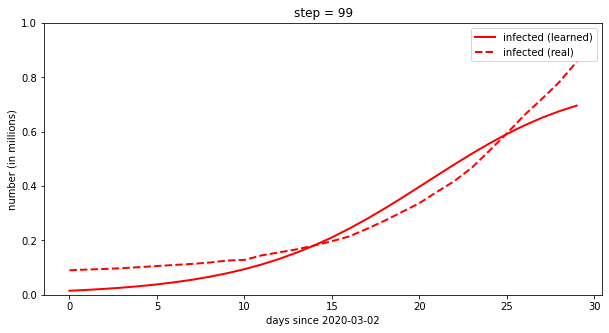

In [96]:
def init():
    global line
    return line


def animate(i):
    global line
    m  = len(infected_history[i])
    line[0].set_data(np.arange(m), infected_history[i])
    plt.title("step = {}".format(i))
    return line

num_frames = 100

fig, ax = plt.subplots(figsize=(10, 5))
line = ax.plot(xt[:, 1].cpu().detach().numpy(), 'r', lw=2, label='infected (learned)')
ax.plot(real_data[:, 0].cpu().detach().numpy(), 'r--', lw=2, label='infected (real)')
ax.set_ylabel('number (in millions)')
d = world_data.index.values[first_day]
d = np.datetime_as_string(d, unit='D')
ax.set_xlabel('days since {}'.format(d))
ax.set_ylim(0, 1.)
plt.legend()


anim_infected = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=num_frames, interval=100, blit=True)

anim_infected

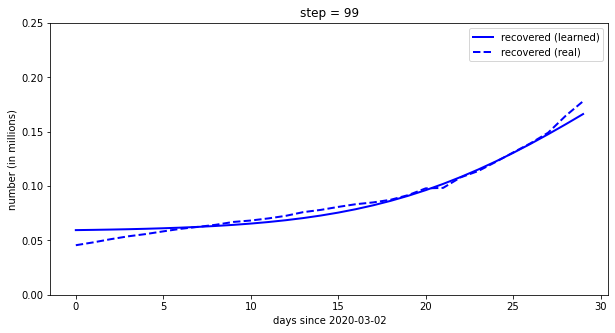

In [97]:
def init():
    global line
    return line


def animate(i):
    global line
    m  = len(recovered_history[i])
    line[0].set_data(np.arange(m), recovered_history[i])
    plt.title("step = {}".format(i))
    return line

fig, ax = plt.subplots(figsize=(10, 5))
line = ax.plot(xt[:, 2].cpu().detach().numpy(), 'b', lw=2, label='recovered (learned)')
ax.plot(real_data[:, 2].cpu().detach().numpy(), 'b--', lw=2, label='recovered (real)')
ax.set_ylabel('number (in millions)')
ax.set_xlabel('days since {}'.format(d))
ax.set_ylim(0, 0.25)
plt.legend()


anim_recovered = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=num_frames, interval=100, blit=True)

anim_recovered

# US data

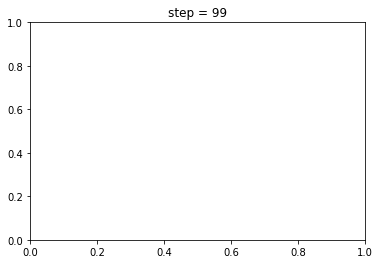

In [100]:
anim_infected.save('animations/infected.gif', writer='imagemagick', fps=60)
anim_recovered.save('animations/recovered.gif', writer='imagemagick', fps=60)

In [101]:
!ls animations

infected.gif  recovered.gif
